# ADA Project : Milestone 2  

#### Useful libraries

In [78]:
# Utilitaries
import pandas as pd
import bz2
import json
import re
import pickle
import string

# Math
import math
import statistics as stat
import numpy as np

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural language processing libraries
from langdetect import detect # for quotes language filtering
import nltk, spacy, sklearn
from spacy.lang.en import English
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Analysis of the lexical fields
from empath import Empath 

# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [82]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
lexicon = Empath()

## Data importation

We started by extracting the quotation corpus of the Pope and of a few politicians from the Quotebank collection using our Google Collab file "Import_Quotebank_Colab.ipynb". We end up with much smaller datasets containing between 10'000 and 100'000 quotes which are much easier to manipulate. From those smaller JSON files, we then decided to build individual pandas dataframes  using the function _build_dataframe_, and saved them in the pickle format for an optimized utilization. The advantage of keeping one file per speaker is the small size of the files (between 10 and 20 Mo) that allows us to import them on our git repository. Our function _import_dataframe_ simply allows to open one of those pickles files.

In [4]:
def build_dataframe(name_speaker):

    file = '../data/'+ name_speaker +'-quotes.json.bz2'
    output = '../data/'+ name_speaker + '-quotes.pkl'
    data = []

    with bz2.open(file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance)

            row = []
            row.extend([instance['quotation'],instance['speaker'], instance['probas'][0][1]])

            if len(instance['probas']) > 1:       #There are at least 2 speakers
                row.extend([instance['probas'][1][0], instance['probas'][1][1]])
            else:
                row.extend([math.nan, math.nan])

            if len(instance['probas']) > 2:       #There are at least 3 speakers
                row.extend([instance['probas'][2][0], instance['probas'][2][1]])
            else:
                row.extend([math.nan, math.nan])

            row.extend([instance['date'], instance['numOccurrences'], instance['phase'], instance['nbr_words'], len(instance['quotation']), len(instance['probas'])])

            data.append(row)

    df = pd.DataFrame(data, columns =['quote', 'speaker', 'probability', 'second_speaker', 'second_probability', 'third_speaker', 'third_probability', 'date', 'nbr_occurences', 'phase', 'nbr_words', 'nbr_characters', 'nbr_speakers'])
    df.to_pickle(output)
    
    
    
def import_dataframe(name_speaker):
    
    file = '../data/'+ name_speaker +'-quotes.pkl'
    return pd.read_pickle(file)

We also chose to build temporary large dataframe with all our 7 speakers of interest as we will perform the same pre-processing steps on all of their quotes.

In [49]:
speakers = ['Mike_Pence','Mitt_Romney','Hillary_Clinton','Bernie_Sanders','Elizabeth_Warren','Ted_Cruz']
df = import_dataframe('Pope')

for s in speakers:
    # uncomment next line if you haven't generated the pickle files yet
    build_dataframe(s) 
    temp = import_dataframe(s)
    df = df.append(temp, ignore_index=True)

In [83]:
df.head(5)

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers,pre_processed_quote,tokenized_quote,lemmatized_quote
354933,And it has got much more dangerous over the la...,Ted Cruz,0.9050,None,0.0950,NaN,NaN,2015-05-16 22:26:09,1,E,12,59,2,ha got dangerous year,"[and, it, has, got, much, more, dangerous, ove...","[and, it, ha, got, much, more, dangerous, over..."
354934,impugning the integrity and veracity,Ted Cruz,0.6836,None,0.2033,James Comey,0.1038,2015-11-17 22:17:20,1,E,5,36,4,impugning integrity veracity,"[impugning, the, integrity, and, veracity]","[impugning, the, integrity, and, veracity]"
354935,"In tech centers like Seattle, which boasts an ...",Ted Cruz,0.8312,None,0.1688,NaN,NaN,2015-03-23 14:30:27,1,E,31,191,2,tech center like seattle boast estimated start...,"[in, tech, centers, like, seattle, which, boas...","[in, tech, center, like, seattle, which, boast..."
354936,"In the past six years, too much of NASA's focu...",Ted Cruz,0.8711,None,0.1271,Bill Nelson,0.0018,2015-03-14 18:45:42,1,E,32,179,3,past year nasa focus ha driven political agend...,"[in, the, past, six, years, too, much, of, nas...","[in, the, past, six, year, too, much, of, nasa..."
354937,"Hold on a second -- Sir, come forward. You wan...",Ted Cruz,0.6588,None,0.3272,Medea Benjamin,0.0140,2015-07-24 01:15:00,2,E,16,79,3,hold second sir come forward want discussion,"[hold, on, a, second, sir, come, forward, you,...","[hold, on, a, second, sir, come, forward, you,..."


## Pre-processing

### Change probabilities type

Our first pre-processing step consists in changing the probabilities columns type from object to float numbers in order to evaluate them properly later on.

In [84]:
new_df = df.copy()

new_df = new_df.astype({'probability': 'float64', 'second_probability': 'float64', 'third_probability': 'float64'})

### Speaker probability thresholding

Each quote has a probability assigned by the algorithm that indicates the certainity (or not) it was said from the given speaker. One possible way is to put a threshold of 50% below which a quote will be removed from the dataset: 

if probability >= 0.5, it means we are more confident that the speaker truly said the quote than someone else said it. Let's first try to check the probability distribution for the main character of interest, the Pope:

In [85]:
plt.hist(new_df.query('speaker == "Pope Francis"').probability,bins=100)
plt.axvline(x = 0.5, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.xlabel('first speaker probability')
plt.ylabel('number of quotes')
_ = plt.title('Pope Francis quotes probability distribution (red line at probability = 0.5)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The red line threshold at probability = 0.5 coincides with an abrupt drop of quotes frequency when Quobert assignes them a probability of less than 50 %. Now let's look at the same distributions for our american politicians.

In [53]:
new_df.head(5)

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers
0,"a good father knows how to wait, and knows how...",Pope Francis,0.7727,None,0.2215,Thomas Rosica,0.0058,2015-02-06 15:31:07,2,E,18,87,3
1,"I don't have an ear for it,",Pope Francis,0.7834,None,0.1408,Mark Miles,0.0758,2015-09-25 01:44:00,1,E,8,27,3
2,Ask `What does this say to my heart? What is G...,Pope Francis,0.9272,None,0.0728,NaN,NaN,2015-12-03 21:20:49,1,E,17,82,2
3,"Be praised, my Lord, through our sister Mother...",Pope Francis,0.7581,None,0.2419,NaN,NaN,2015-06-19 00:49:49,1,E,24,137,2
4,But he's already taken a number of important s...,Pope Francis,0.5039,None,0.4961,NaN,NaN,2015-07-28 19:34:53,2,E,20,103,2


In [55]:
speakers = ['Pope Francis','Hillary Clinton','Bernie Sanders',
            'Elizabeth Warren','Mike Pence','Mitt Romney','Ted Cruz']

<Figure size 432x288 with 0 Axes>

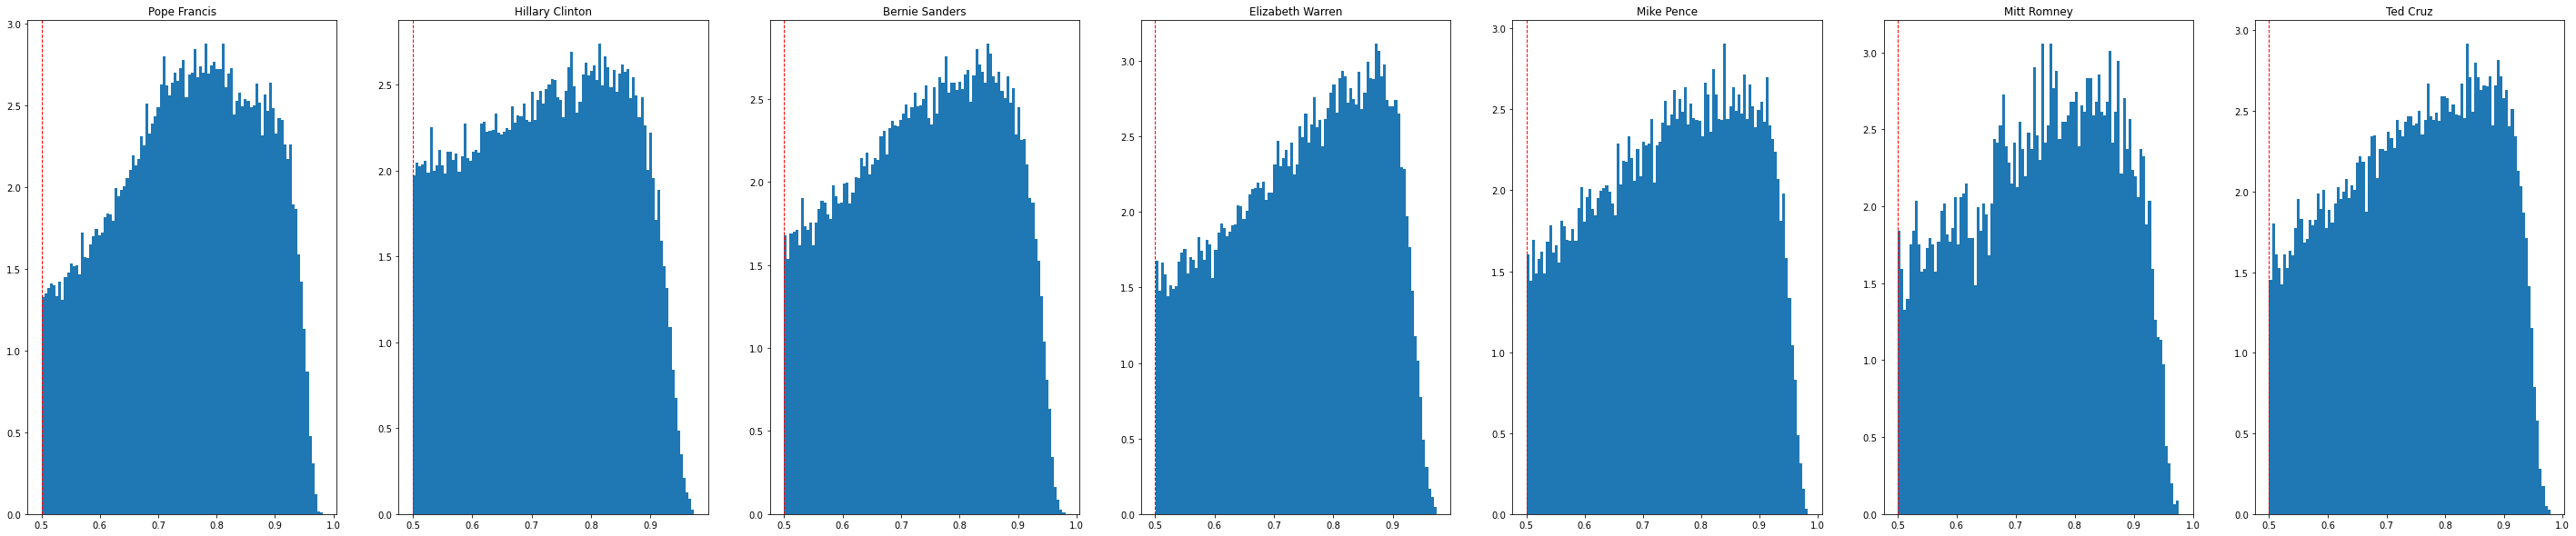

In [60]:
plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 7, figsize = (50,10))
plt.title("Normalized distributions of quotes probabilites per speaker")
i = 0
for col in ax:
    data = new_df.loc[new_df.speaker == speakers[i]].probability
    col.hist(data, density = True, bins = 100)
    col.axvline(x = 0.5, color = 'r', linestyle = 'dashed', linewidth = 1)
    col.title.set_text(speakers[i])
    i += 1

plt.show()

In [86]:
plt.figure(figsize = (8,8))
ax = sns.boxplot(y = 'probability', x = 'speaker', palette = "colorblind", data = new_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
_ = plt.title("Probability for quotes assigned to speakers")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# try new method to remove quotes according to more 'robust' threshold
new_df.drop(new_df.query('probability <= 0.5').index, inplace=True)
new_df = new_df.reset_index(drop=True)

In [87]:
plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (50,10))
i = 0
for col in ax:
    data = new_df[new_df.speaker == speakers[i]].probability
    col.hist(data, density = True, bins = 100)
    col.axvline(x = data.median(), color = 'r', linestyle = 'dashed', linewidth = 1)
    col.title.set_text(speakers[i])
    i += 1
    
#plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: ('Lengths must match to compare', (41722,), (2,))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Natural Language pre-processing steps

To handle text properly for natural language processing, a set of classical operations must be done. We save a new version of the quotes without digits, punctuation, unecessary spaces and capital letters. 

In [61]:
# remove digits
new_df['pre_processed_quote'] = new_df['quote'].astype(str).str.replace('\d+', '', regex=True)

# remove punctuation
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].apply(lambda x: re.sub(r'[^\w\s]','', x))

# remove spaces at the beginning and ending of quotes
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.strip()

# remove capitalization from words
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.lower()

Then we remove rows that contain an empty quote or a quote that only contains digits and/or punctuation. For example we found a quote that was written in binary. This step only removes three rows for all our speakers.

In [62]:
print("Before removing aberrant rows : " + str(len(new_df)))

# remove rows with empty or NaN quotes (so also the ones which only had digits &/or punctuation)
new_df['pre_processed_quote'].replace("", np.nan, inplace=True)
new_df.dropna(subset = ["pre_processed_quote"], inplace=True)

print("After removing aberrant rows : " + str(len(new_df)))

Before removing aberrant rows : 396655
After removing aberrant rows : 396652


Then, we also save a tokenized and a lemmatized version of the quote in our dataframe. The tokenization is notably useful to later ignore stop words (a, and, but, how...) and for lexical fields analysis. The Lemmatization is useful for ignoring the variations of words (e.g. plurals and verbs) and concentrate on their meaning.

In [63]:
# Quotes tokenization 
new_df['tokenized_quote'] = new_df['pre_processed_quote'].apply(lambda x: tokenizer.tokenize(x)) 

# Quotes lemmatization  
new_df['lemmatized_quote'] = new_df['tokenized_quote'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
# careful ! poor lemmatization (does -> doe, has -> ha etc)

Finally, we save an last version of the quotes which consists in the tokenized version without the stop words.

In [67]:
# remove stop words
stop_words = stopwords.words('english')
stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)
stop_words.extend([singer.capitalize() for singer in stop_words]) #stop words with capitale
stop_words.extend(list(string.punctuation))

new_df['pre_processed_quote'] = new_df['lemmatized_quote'].apply(lambda x: (" ").join([word for word in x if not word in stop_words]))

In [68]:
new_df

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers,pre_processed_quote,tokenized_quote,lemmatized_quote
0,"a good father knows how to wait, and knows how...",Pope Francis,0.7727,None,0.2215,Thomas Rosica,0.0058,2015-02-06 15:31:07,2,E,18,87,3,good father know wait know forgive heart,"[a, good, father, knows, how, to, wait, and, k...","[a, good, father, know, how, to, wait, and, kn..."
1,"I don't have an ear for it,",Pope Francis,0.7834,None,0.1408,Mark Miles,0.0758,2015-09-25 01:44:00,1,E,8,27,3,dont ear,"[i, dont, have, an, ear, for, it]","[i, dont, have, an, ear, for, it]"
2,Ask `What does this say to my heart? What is G...,Pope Francis,0.9272,None,0.0728,NaN,NaN,2015-12-03 21:20:49,1,E,17,82,2,ask doe heart god saying word,"[ask, what, does, this, say, to, my, heart, wh...","[ask, what, doe, this, say, to, my, heart, wha..."
3,"Be praised, my Lord, through our sister Mother...",Pope Francis,0.7581,None,0.2419,NaN,NaN,2015-06-19 00:49:49,1,E,24,137,2,praised lord sister mother earth feed u rule u...,"[be, praised, my, lord, through, our, sister, ...","[be, praised, my, lord, through, our, sister, ..."
4,But he's already taken a number of important s...,Pope Francis,0.5039,None,0.4961,NaN,NaN,2015-07-28 19:34:53,2,E,20,103,2,taken number important step think pave way fut...,"[but, hes, already, taken, a, number, of, impo...","[but, he, already, taken, a, number, of, impor..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396650,"about an infant who has been born, who is aliv...",Ted Cruz,0.9307,None,0.0624,Amy Klobuchar,0.0044,2020-02-13 12:37:50,1,E,46,252,4,infant ha born alive breathing cry outside wom...,"[about, an, infant, who, has, been, born, who,...","[about, an, infant, who, ha, been, born, who, ..."
396651,Each of the physicians that I consulted with a...,Ted Cruz,0.9179,None,0.0784,Lindsey Graham,0.0014,2020-03-18 23:18:43,3,E,27,151,6,physician consulted advised symptom im sick sa...,"[each, of, the, physicians, that, i, consulted...","[each, of, the, physician, that, i, consulted,..."
396652,"The House managers were saying, `Oh, we can do...",Ted Cruz,0.7648,None,0.1344,Sean Hannity,0.0817,2020-02-15 19:31:12,4,E,19,89,5,house manager saying oh week itll quick easy,"[the, house, managers, were, saying, oh, we, c...","[the, house, manager, were, saying, oh, we, ca..."
396653,I commend @realDonaldTrump for leaning in hard...,Ted Cruz,0.8115,None,0.1014,Shelley Moore Capito,0.0831,2020-01-17 00:00:00,2,E,39,227,4,commend realdonaldtrump leaning hard work fair...,"[i, commend, realdonaldtrump, for, leaning, in...","[i, commend, realdonaldtrump, for, leaning, in..."


### Non-english quotes removal

The Quotebank corpus is mainly composed of quotes in the English language. However, we did notice that a few quotes in other languages managed to find their way in the dataset. To perform efficient natural language processing, we decided to remove every quote that isn't considered as english. This task will be done with the NLP language detection library 'langdetect' that supports over 55 different languages.

In [ ]:
new_df = new_df.reset_index(drop=True)
index = []

# 30 min !!
for n, quote_ in enumerate(new_df['quote']) :
    value = detect(quote_)
    if value != "en":
        index.append(n)

In [ ]:
new_df.drop(index, inplace=True)
new_df = new_df.reset_index(drop=True)

#print("Percentage of non-english quotes that were removed :", round((len(df)-len(new_df))/len(df)*100, 2))

In summary, our whole pre-processing procedure ended up removing only a small percentage of the quotations.

In [69]:
print((len(df)-len(new_df))/len(df))

0.08755011950468242


We save the pre-processed version of our dataframe for facilitated usage.

In [70]:
new_df.to_pickle("../data/pre_processed_df.pkl")

## Exploratory analysis

## Features extraction (data processing)

Characters will be assigned a label based on their political party: 0 = apolitical (Pope), 1 = Democrats, 2 = Republicans

In [71]:
# Extract features
speakers = [['Pope Francis',0],['Hillary Clinton',1],['Bernie Sanders',1],['Elizabeth Warren',1],['Mike Pence',2],['Mitt Romney',2],['Ted Cruz',2]]
all_features = pd.DataFrame()

for s in speakers:
    
    df = new_df[new_df['speaker'].str.match(s[0])]
    
    features_nbr_words = pd.DataFrame(data = {'mean_nbr_words': df['nbr_words'].mean(), 'median_nbr_words': df['nbr_words'].median(), 'std_nbr_words': df['nbr_words'].std()}, index=[0])
    features_nbr_chars = pd.DataFrame({'mean_nbr_words': df['nbr_characters'].mean(), 'median_nbr_words': df['nbr_characters'].median(), 'std_nbr_words': df['nbr_characters'].std()}, index=[0])
    features_nbr_occurences = pd.DataFrame({'mean_nbr_words': df['nbr_occurences'].mean(), 'median_nbr_words': df['nbr_occurences'].median(), 'std_nbr_words': df['nbr_occurences'].std()}, index=[0])
    
    #Feature 'vocabulary richness'
    all_words = pd.DataFrame(df['tokenized_quote'].explode(ignore_index=True)).rename({'tokenized_quote': 'word'}, axis=1)
    unique_words = all_words.value_counts().rename_axis('word').reset_index(name='nbr_occurence')
    feature_voc = pd.DataFrame({'voc_richness': len(unique_words)/len(df)}, index=[0])

    #Features 'lexical fields'
    features_lex_fields = pd.DataFrame([lexicon.analyze(df['pre_processed_quote'].str.cat(sep = ' '), categories = ["money","family","health","government",
                                                          "swearing_terms","divine","sexual","business","religion",
                                                         "worship","leader","death","violence","military","war","science","economics","politics","power","terrorism","poor",
                                                      "philosophy","negative_emotion","competing","law", "positive_emotion"])])

    features = pd.concat([features_nbr_words, features_nbr_chars, features_nbr_occurences, feature_voc, features_lex_fields, pd.DataFrame([s[1]], columns=["party"])], axis=1)
    all_features = all_features.append(features)
    all_features.rename(index={0: s[0]}, inplace=True)

all_features.to_pickle("../data/all_features.pkl")
all_features


,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_words,median_nbr_words,std_nbr_words,voc_richness,...,politics,power,terrorism,poor,philosophy,negative_emotion,competing,law,positive_emotion,party
Pope Francis,22.067972,18.0,18.426936,123.605655,98.0,103.438353,7.061845,1.0,39.659879,0.273748,...,10398.0,13145.0,4424.0,9865.0,9724.0,18334.0,4343.0,10844.0,37689.0,0
Hillary Clinton,23.026193,17.0,20.010998,125.152985,94.0,109.977711,7.518674,1.0,33.806072,0.331298,...,22908.0,11223.0,4938.0,7933.0,4875.0,17696.0,9940.0,16718.0,16304.0,1
Bernie Sanders,24.066756,19.0,19.156709,132.924251,105.0,107.071716,5.387202,1.0,22.919723,0.289061,...,31003.0,11162.0,4230.0,13296.0,9272.0,19407.0,11638.0,23081.0,14867.0,1
Elizabeth Warren,23.379393,19.0,18.338015,129.214325,104.0,102.348781,5.434855,1.0,21.778052,0.451425,...,13159.0,9639.0,1797.0,6395.0,2967.0,12873.0,6913.0,15957.0,8945.0,1
Mike Pence,22.991186,19.0,17.243502,129.760187,106.0,98.475596,9.882309,1.0,50.037261,0.451088,...,14321.0,10820.0,4815.0,3555.0,3344.0,4918.0,3893.0,11516.0,10895.0,2
Mitt Romney,23.304357,18.0,19.755444,127.571368,99.0,110.596289,7.801983,1.0,36.372671,1.022787,...,3544.0,1583.0,625.0,916.0,568.0,1771.0,1363.0,2637.0,2044.0,2
Ted Cruz,23.672211,18.0,20.313107,132.865778,102.0,115.203240,5.587795,1.0,28.559549,0.491012,...,19919.0,9351.0,5086.0,3371.0,3388.0,9133.0,6338.0,15987.0,7185.0,2


## PCA

In [72]:
#centrer et normaliser FIND BETTER selection of columns (take all of them except the last one, party)

features = all_features.loc[:, all_features.columns != 'party']
features_with_party = all_features

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(features), columns = features.columns).copy()


nbr_components = min(len(features.columns), len(features))

%matplotlib inline

pca_screeplot = PCA(n_components=nbr_components)
pca_screeplot.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

#percentage variance explaines
ratio = pca_screeplot.explained_variance_ratio_
print('The 2D PCA contains',round((ratio[0]+ratio[1])*100),'% of the information' )
print("")

print ('Component 1 contains',ratio[0]*100,'% of the information' )
print ('Component 2 contains',ratio[1]*100,'% of the information' )
print ('Component 3 contains',ratio[2]*100,'% of the information' )
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2]]))*100,'% of the information has been lost' )
print ('Component 4 contains',ratio[3]*100,'% of the information' )
print ('Component 5 contains', ratio[4]*100,'% of the information' )
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2],ratio[3],ratio[4]]))*100,'% of the information has been lost' )


The 2D PCA contains 76.0 % of the information

Component 1 contains 45.95483059398648 % of the information
Component 2 contains 29.690026995263448 % of the information
Component 3 contains 11.33093372653519 % of the information
So far, 13.024208684214889 % of the information has been lost
Component 4 contains 7.5679240335545 % of the information
Component 5 contains 3.7398943029239713 % of the information
So far, 1.7163903477364184 % of the information has been lost


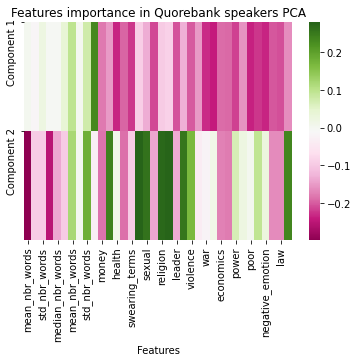

In [73]:
#Interpretation of the components (permet de voir quelle(s) feature(s) sont le plus importantes!)

%matplotlib inline

pca_2d = PCA(n_components=2)
pca_2d.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

map_ = pd.DataFrame(pca_2d.components_,columns=scaled_df.columns)
sns.heatmap(map_,cmap="PiYG")
plt.title("Features importance in Quorebank speakers PCA")
plt.yticks([0,1],['Component 1','Component 2'], fontsize=10)
plt.xlabel('Features')
plt.show()

In [74]:
#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

#3D PCA
PCA_3d = PCA(n_components=3)
PCs_3 = PCA_3d.fit_transform(scaled_df)
res_PCA_3d = pd.DataFrame(data = PCs_3, columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])


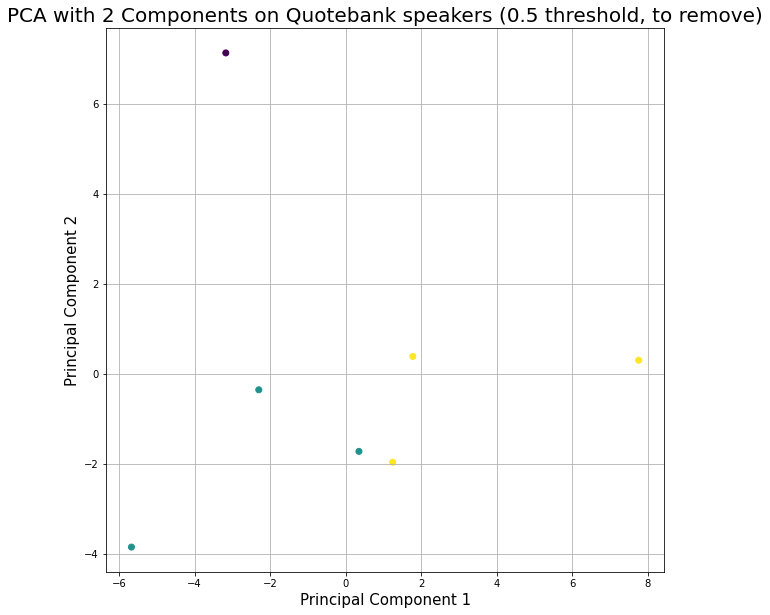

In [75]:
#Visualize results 2D PCA
%matplotlib inline

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  
plt.title("PCA with 2 Components on Quotebank speakers (0.5 threshold, to remove)",fontsize=20) 

plt.scatter(res_PCA_2d.loc[:,'Principal component 1'], res_PCA_2d.loc[:,'Principal component 2'], c = all_features['party'])

plt.grid()
plt.savefig("../data/PCA_visualization.png")
plt.show()

In [76]:
#Visualize results 3D PCA
%matplotlib notebook

plt.figure(figsize=(10,8))

ax = plt.axes(projection="3d")
ax.set_xlabel('Principal Component - 1',fontsize=15)
ax.set_ylabel('Principal Component - 2',fontsize=15)
ax.set_zlabel('Principal Component - 3',fontsize=15)

plt.title("PCA with 3 Components on Quotebank speakers data, 0.5",fontsize=20)

ax.scatter(res_PCA_3d.loc[:, 'Principal component 1'], res_PCA_3d.loc[:, 'Principal component 2'], res_PCA_3d.loc[:, 'Principal component 3'], s =150, c = all_features['party'])

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>